In [27]:
!pip install git+https://github.com/tensorflow/docs



  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-m2f7wfir
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-m2f7wfir
     |████████████████████████████████| 1.0MB 4.0MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.07d6de2784363a81e65d5af245dc41b3e71eb65b5_-cp37-none-any.whl size=153742 sha256=25ff52b6b07533d302eadae297389a122944422ebffda69d3a2f65441e07b297
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tx2f30a/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


# Connecting to drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


# Importing Libraries

In [2]:
import glob
import os

import imageio
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from numpy.random import randint
import PIL
import tensorflow as tf
import cv2

# Loading Files

In [ ]:
images = np.load('/content/drive/MyDrive/Breast_Gan/X.npy')
labels = np.load('/content/drive/MyDrive/Breast_Gan/Y.npy')

print(f'shape of images : {images.shape}')
print(f'shape of labels : {labels.shape}')

shape of images : (5547, 50, 50, 3)
shape of labels : (5547,)


# Ploting some examples

(-0.5, 49.5, 49.5, -0.5)

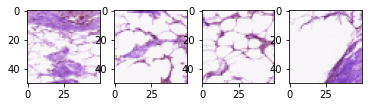

In [ ]:
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(images[3], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(images[4], cv2.COLOR_BGR2RGB))
plt.axis("on")


In [ ]:
print(f'Size of images single image : {images[0].shape}')
print(f'Type of images single image : {images[0].max()}')

Size of images single image : (50, 50, 3)
Type of images single image : 252


In [ ]:
def preprocess_images(images_dataset):

    images_dataset = (images_dataset - 127.5) / 127.5
    return images_dataset

X = preprocess_images(images)

# Defining Model

## Discriminator

In [ ]:
def build_discriminator(input_shape = (50,50,3)):

    discriminator = tf.keras.Sequential([

        tf.keras.layers.Conv2D(64, (3,3), padding = 'same', input_shape = input_shape, activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Input_layer'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_1'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_2'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_3'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_4'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
            ])

    opt = tf.keras.optimizers.Adam(lr= 0.0002, beta_1 = 0.5)
    discriminator.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


    return discriminator

In [ ]:
discriminator_test = build_discriminator()
discriminator_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Conv2D)         (None, 50, 50, 64)        1792      
_________________________________________________________________
Downsampling_1 (Conv2D)      (None, 25, 25, 128)       73856     
_________________________________________________________________
Downsampling_2 (Conv2D)      (None, 13, 13, 128)       147584    
_________________________________________________________________
Downsampling_3 (Conv2D)      (None, 7, 7, 128)         147584    
_________________________________________________________________
Downsampling_4 (Conv2D)      (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Generator

In [ ]:
def build_generator(lattent_dimension = 100):

    """
    Padding : if "same" Wout = Win * stride, if "valid" Wout = (Win-1) + Stride * Ksize

    """

    n_nodes = 256 * 5 * 5

    generator = tf.keras.Sequential([

        tf.keras.layers.Dense(n_nodes, input_dim = lattent_dimension, activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Dense_in'),
        tf.keras.layers.Reshape((5, 5, 256), name = 'Reshaping'),
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_1'), # upsampling to :10 x 10
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_2'), # upsampling to :20 x 20
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_3'), # upsampling to :40 x 40
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(128, (11,11), strides = (1,1), padding = 'valid',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_4'), # upsampling to :50 x 50
        tf.keras.layers.Conv2D(3, (3,3), activation = 'tanh', padding = 'same', name = 'Discriminator_fitting') # Formating the ouutput of generator to match discriminator input
    ])

    return generator

In [ ]:
test_generator = build_generator()

In [ ]:
test_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_in (Dense)             (None, 6400)              646400    
_________________________________________________________________
Reshaping (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
Upsampling_1 (Conv2DTranspos (None, 10, 10, 128)       524416    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 128)       512       
_________________________________________________________________
Upsampling_2 (Conv2DTranspos (None, 20, 20, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 128)       512       
_________________________________________________________________
Upsampling_3 (Conv2DTranspos (None, 40, 40, 128)      

## Gan Model

In [ ]:
def build_gan(generator_model, discriminator_model):

    discriminator_model.trainable = False

    model = tf.keras.Sequential([

        generator_model,
        discriminator_model
    ])

    opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)

    return model

In [ ]:
test_gan = build_gan(test_generator, discriminator_test)
test_gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 50, 50, 3)         3682947   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 520449    
Total params: 4,203,396
Trainable params: 3,682,179
Non-trainable params: 521,217
_________________________________________________________________


In [ ]:
def generate_real_samples(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples,1))

    return X, y 

In [ ]:
def generate_latent_points(latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(generator_model, lattent_dimension, n_samples):

    x_input = generate_latent_points(lattent_dimension, n_samples) # generate points in the latent space
    X = generator_model.predict(x_input) # prediction from generated points
    y = np.zeros((n_samples, 1)) # creating fake class (0)

    return X, y

In [ ]:
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = '/content/drive/MyDrive/Breast_Gan/Models_and_images/generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()


In [ ]:
def summarize_performance(epoch, generator_model, discriminator_model, dataset, lattent_dimension, n_samples = 150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator_model, lattent_dimension, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = '/content/drive/MyDrive/Breast_Gan/Models_and_images/generator_model_%03d.h5' % (epoch+1)
	generator_model.save(filename)
 

def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	plt.subplot(2, 1, 1)
	plt.plot(d1_hist, label='d-real')
	plt.plot(d2_hist, label='d-fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	# plot discriminator accuracy
	plt.subplot(2, 1, 2)
	plt.plot(a1_hist, label='acc-real')
	plt.plot(a2_hist, label='acc-fake')
	plt.legend()
	# save plot to file
	plt.savefig('/content/drive/MyDrive/Breast_Gan/Models_and_images/plot_line_plot_loss.png')
	plt.close()

### Defining training

In [ ]:
def train_gan(generator_model, discriminator_model, gan_model, dataset, lattent_dimension, n_epochs = 200, n_batch = 128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d1_hist = []
  d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list()
	# manually enumerate epochs
  for i in range(n_epochs):
		# enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, d_acc1 = discriminator_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(generator_model, lattent_dimension, half_batch)
      # update discriminator model weights
      d_loss2, d_acc2 = discriminator_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(lattent_dimension, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      # record history
      d1_hist.append(d_loss1)
      d2_hist.append(d_loss2)
      g_hist.append(g_loss)
      a1_hist.append(d_acc1)
      a2_hist.append(d_acc2)
		# evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, generator_model, discriminator_model, dataset, lattent_dimension)

  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)   

## Performing Experience

In [ ]:
lattent_dimension = 100

discriminator_model = build_discriminator()

generator_model = build_generator(lattent_dimension)

gan_model = build_gan(generator_model, discriminator_model)

dataset = preprocess_images(images)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
with tf.device('/GPU:0'):
  train_gan(generator_model, discriminator_model, gan_model, dataset, lattent_dimension, n_epochs = 200, n_batch = 8 )

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
>193, 547/693, d1=0.000, d2=0.014 g=0.256
>193, 548/693, d1=0.000, d2=0.010 g=0.195
>193, 549/693, d1=0.000, d2=0.019 g=0.269
>193, 550/693, d1=0.001, d2=0.011 g=0.046
>193, 551/693, d1=0.367, d2=0.119 g=0.045
>193, 552/693, d1=0.000, d2=0.064 g=0.115
>193, 553/693, d1=0.000, d2=0.056 g=0.692
>193, 554/693, d1=0.000, d2=0.016 g=0.368
>193, 555/693, d1=0.000, d2=0.020 g=0.191
>193, 556/693, d1=0.000, d2=0.034 g=0.196
>193, 557/693, d1=0.386, d2=0.079 g=0.327
>193, 558/693, d1=0.000, d2=0.158 g=0.642
>193, 559/693, d1=0.683, d2=0.111 g=0.054
>193, 560/693, d1=0.000, d2=0.021 g=0.063
>193, 561/693, d1=0.051, d2=0.104 g=0.120
>193, 562/693, d1=0.195, d2=0.073 g=0.375
>193, 563/693, d1=0.001, d2=0.069 g=0.493
>193, 564/693, d1=0.046, d2=0.056 g=0.530
>193, 565/693, d1=0.000, d2=0.110 g=0.285
>193, 566/693, d1=0.000, d2=0.039 g=0.882
>193, 567/693, d1=0.004, d2=0.044 g=0.529
>193, 568/693, d1=0.000, d2=0.046 g=1.14

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/drive/MyDrive/Breast_Gan/Models_and_images/generated_plot_e0' + str(epoch_no) +'.png')

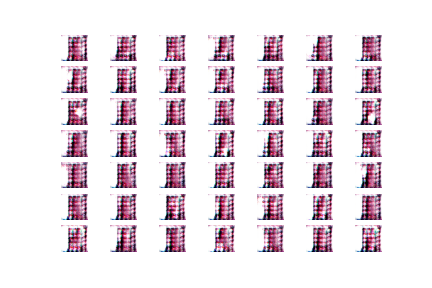

In [23]:
display_image(10)


In [24]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/Breast_Gan/Models_and_images/generated_plot*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


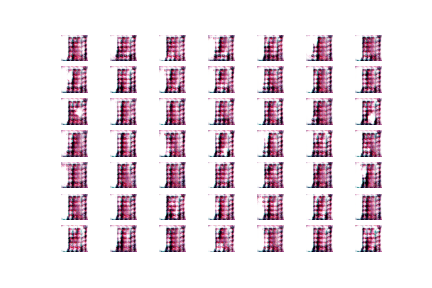

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Generating images

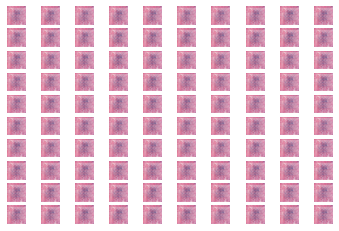

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()
 
# load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Breast_Gan/Models_and_images/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

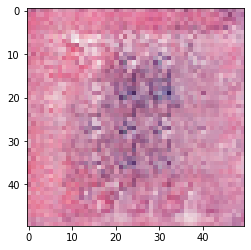

In [9]:
# load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Breast_Gan/Models_and_images/generator_model_200.h5')
# all 0s
vector = np.asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plt.imshow(X[0, :, :])
plt.show()